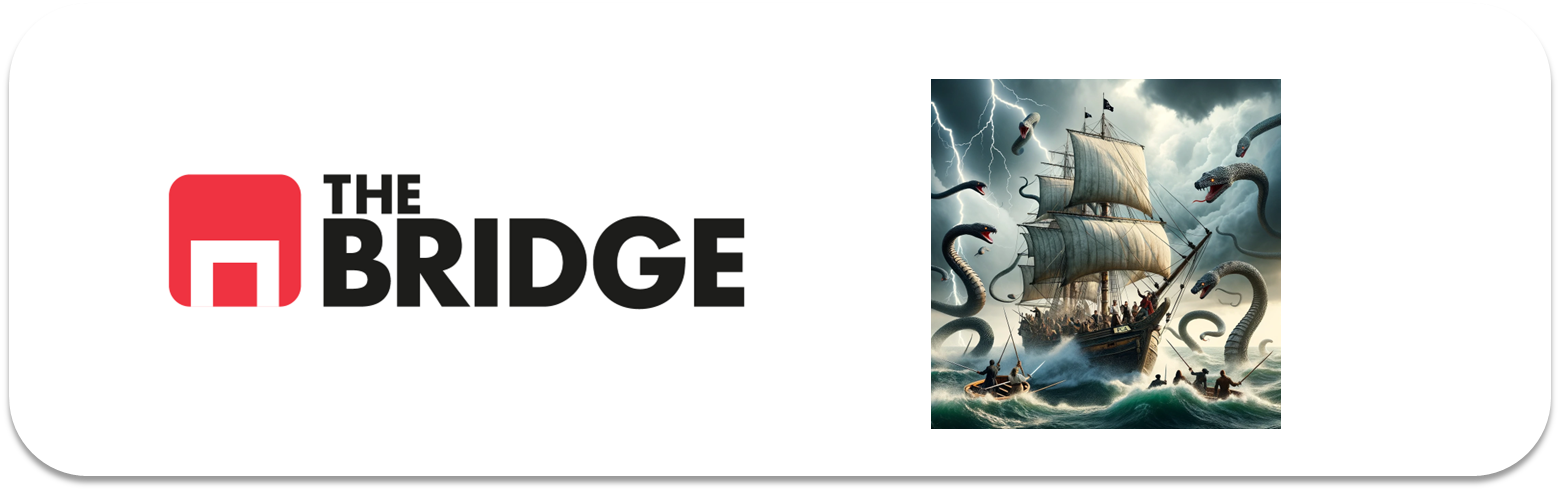

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [234]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import ToolBox as tb
import bootcampviztools as viz

from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel, VarianceThreshold, RFECV, SequentialFeatureSelector
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, mutual_info_score

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [156]:
df = pd.read_csv("./data/credit_npo.csv").dropna()
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [158]:
df.NumberOfDependents = df.NumberOfDependents.astype(int)

#### *"NumberOf" a categóricas*

In [159]:
for col in [col for col in df if col.startswith("Number")]:
    print(df[col].value_counts())

NumberOfTime30-59DaysPastDueNotWorse
0     9818
1     1354
2      397
3      127
4       64
5       23
6       20
98      10
8        2
7        1
Name: count, dtype: int64
NumberOfOpenCreditLinesAndLoans
7     1110
6     1031
8     1009
9      965
5      963
4      848
10     765
11     719
3      638
12     574
13     454
2      445
14     365
15     338
1      307
16     236
17     216
18     151
19     129
20     118
0      112
21      62
22      61
23      39
24      38
25      30
26      19
27      16
28      13
29      10
30      10
31       7
33       4
32       3
34       2
35       2
36       1
38       1
43       1
48       1
49       1
41       1
40       1
Name: count, dtype: int64
NumberOfTimes90DaysLate
0     11156
1       394
2       142
3        54
4        31
5        14
98       10
6         6
8         3
7         3
10        1
9         1
13        1
Name: count, dtype: int64
NumberRealEstateLoansOrLines
0     4233
1     4149
2     2585
3      530
4      179
5     

In [160]:
for col in [col for col in df if col.startswith("NumberOf")]:
    df[f"{col[8:]}_cat"] = 0
    df.loc[df[col]> 0, f"{col[8:]}_cat"] = 1
    df.loc[df[col]> 2, f"{col[8:]}_cat"] = 2


In [161]:
df["RealEstateLoansOrLines_cat"] = 0
df.loc[df["NumberRealEstateLoansOrLines"] > 0, "RealEstateLoansOrLines_cat"] = 1
df.loc[df["NumberRealEstateLoansOrLines"] > 1, "RealEstateLoansOrLines_cat"] = 2
df.loc[df["NumberRealEstateLoansOrLines"] > 2, "RealEstateLoansOrLines_cat"] = 3

In [162]:
df = df[[col for col in df if not col.startswith("Number")]].copy()

In [163]:
[df[col].nunique() for col in df[[col for col in df if not col.startswith("Number")]]]

[2, 10314, 78, 11472, 4167, 3, 3, 3, 3, 3, 4]

In [164]:
df.columns = [col.replace("-", "_").replace(" ","_") for col in df]

In [165]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'DebtRatio', 'MonthlyIncome', 'Time30_59DaysPastDueNotWorse_cat',
       'OpenCreditLinesAndLoans_cat', 'Times90DaysLate_cat',
       'Time60_89DaysPastDueNotWorse_cat', 'Dependents_cat',
       'RealEstateLoansOrLines_cat'],
      dtype='object')

#### *Train, test split*

In [166]:
target = "SeriousDlqin2yrs"

In [167]:
train, test = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)

#### *Análisis visual*

In [168]:
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,Time30_59DaysPastDueNotWorse_cat,OpenCreditLinesAndLoans_cat,Times90DaysLate_cat,Time60_89DaysPastDueNotWorse_cat,Dependents_cat,RealEstateLoansOrLines_cat
2031,0,0.039187,61,0.269356,3073.0,0,2,0,0,0,2
10352,0,0.919317,41,0.162696,3945.0,0,2,0,0,0,0
497,0,0.253718,49,0.247302,13250.0,0,2,0,0,0,2
10341,0,0.249462,26,0.882353,764.0,0,2,0,0,0,0
4043,0,0.224520,76,0.462710,3150.0,0,2,0,0,0,1


##### *Target*

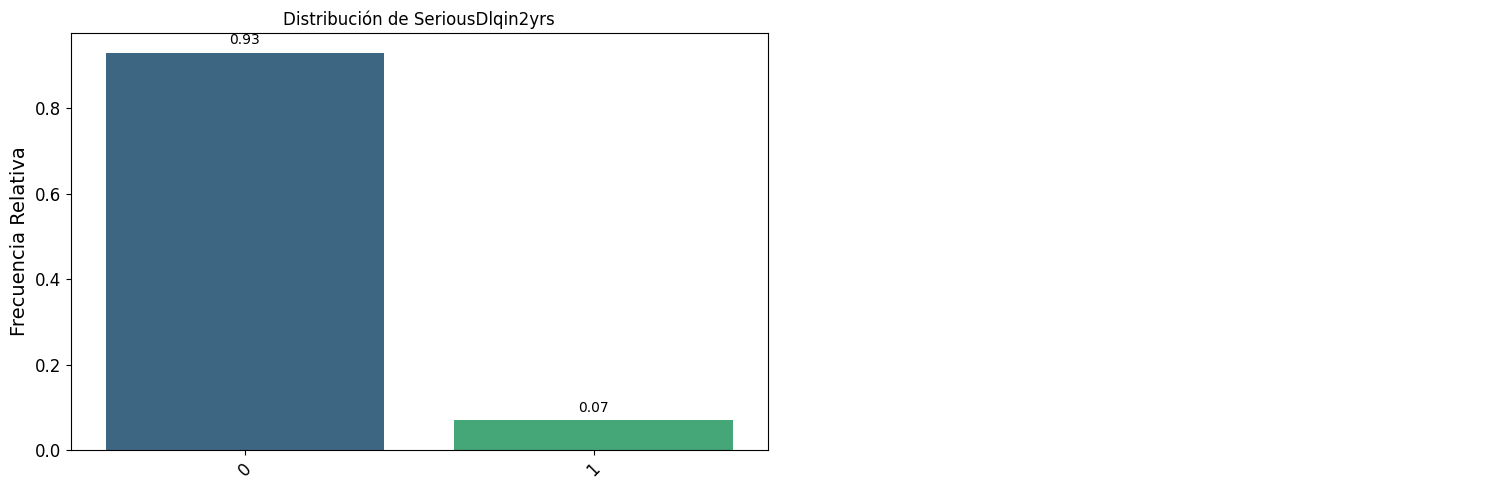

In [169]:
viz.pinta_distribucion_categoricas(df, [target], relativa=True, mostrar_valores=True)

*Tenemos un dataset con un target claramente desbalanceado.*

##### *Numéricas*

In [170]:
num_cols = train.iloc[:, 1:5].columns.to_list()

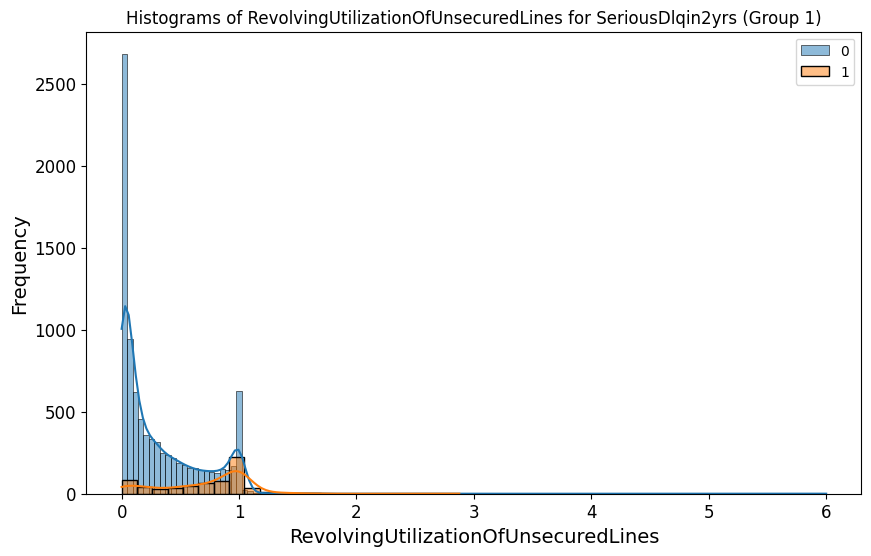

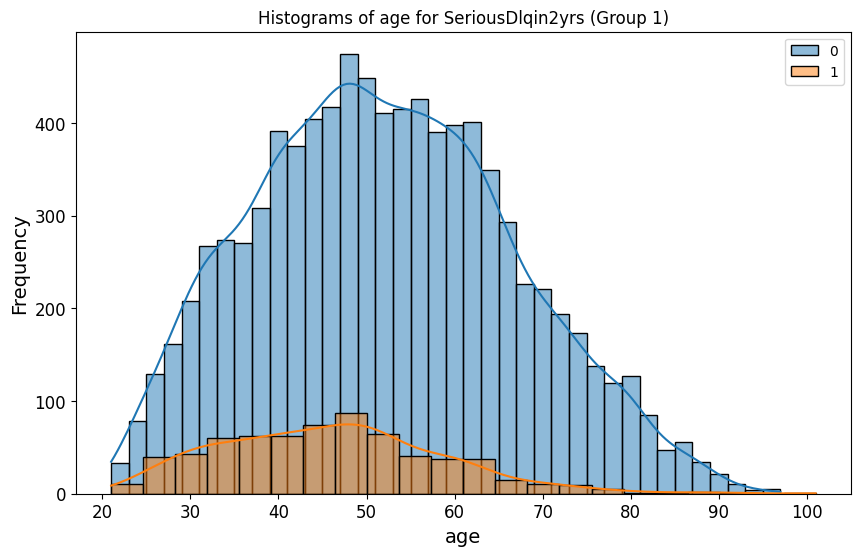

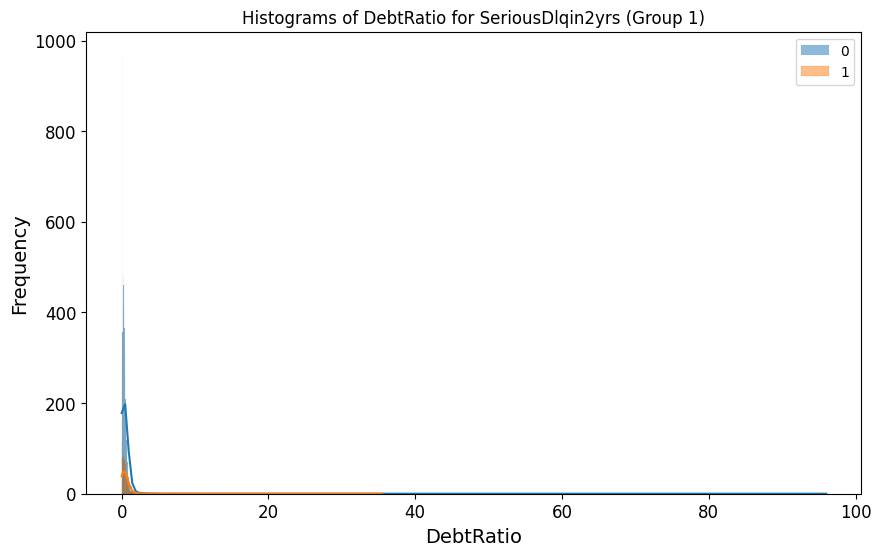

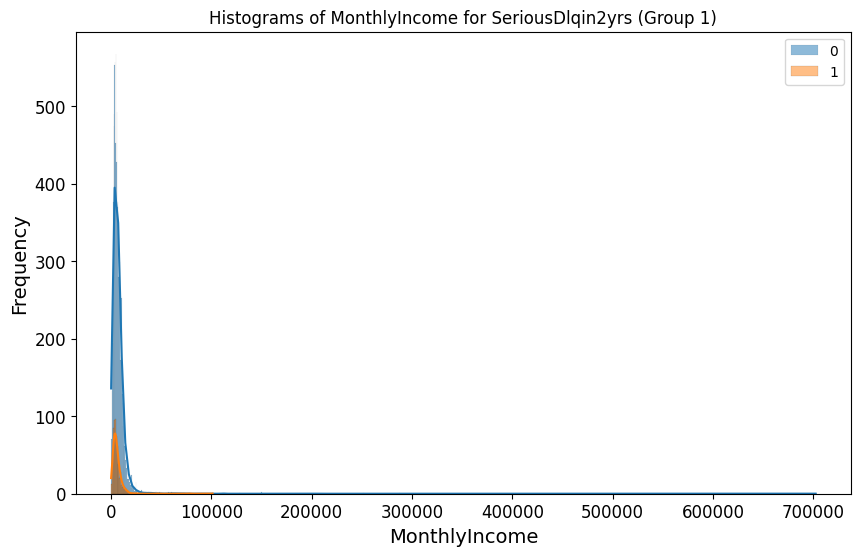

In [171]:
for col in train[num_cols]:
    viz.plot_grouped_histograms(train, target, col, 2)

In [172]:
np.abs(df.iloc[:, 0:5].corr()[target]).sort_values(ascending = False)

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines    0.280350
age                                     0.106076
MonthlyIncome                           0.022199
DebtRatio                               0.001666
Name: SeriousDlqin2yrs, dtype: float64

*Con lo que podemos ver en los histogramas, MonthlyIncome y DebtRatio no parecen ser muy discriminativas en cuanto al target, si parece serlo la utilización de líneas no garantizadas y edad es difícil verlo por la gran diferencia del rango de valores, pero no parecen tener la misma forma las KDEs así que podría ser discriminativa y viendo su correlación podemos corroborar que no es muy fuerte, pero algo correlacionada sí que está con el target.*

*Me quedo como numéricas de primera las dos con mayor correlación.*

In [173]:
f_num_primera = ["RevolvingUtilizationOfUnsecuredLines", "age"]

In [174]:
df.cov()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,Time30_59DaysPastDueNotWorse_cat,OpenCreditLinesAndLoans_cat,Times90DaysLate_cat,Time60_89DaysPastDueNotWorse_cat,Dependents_cat,RealEstateLoansOrLines_cat
SeriousDlqin2yrs,0.065315,0.026167,-0.393533,-0.001148,-6.726295e+01,0.028549,-0.007909,0.027078,0.016576,0.007593,-0.004021
RevolvingUtilizationOfUnsecuredLines,0.026167,0.133378,-1.370189,0.010612,-2.031588e+02,0.041072,-0.030071,0.030622,0.019105,0.016078,-0.035413
age,-0.393533,-1.370189,210.722106,-0.345597,9.168540e+03,-0.456291,0.514173,-0.403893,-0.239538,-1.904067,1.065985
DebtRatio,-0.001148,0.010612,-0.345597,7.268776,-1.168880e+03,-0.001337,0.007745,-0.006242,-0.003197,-0.007582,0.055588
MonthlyIncome,-67.262954,-203.158804,9168.540282,-1168.880498,1.405625e+08,-62.984310,255.037905,-121.016106,-74.073528,601.087572,1716.067730
Time30_59DaysPastDueNotWorse_cat,0.028549,0.041072,-0.456291,-0.001337,-6.298431e+01,0.195722,-0.000302,0.034451,0.032516,0.015866,0.010707
OpenCreditLinesAndLoans_cat,-0.007909,-0.030071,0.514173,0.007745,2.550379e+02,-0.000302,0.094742,-0.016102,-0.004378,0.011353,0.074408
Times90DaysLate_cat,0.027078,0.030622,-0.403893,-0.006242,-1.210161e+02,0.034451,-0.016102,0.082944,0.024326,0.007405,-0.028550
Time60_89DaysPastDueNotWorse_cat,0.016576,0.019105,-0.239538,-0.003197,-7.407353e+01,0.032516,-0.004378,0.024326,0.060471,0.003698,-0.011661
Dependents_cat,0.007593,0.016078,-1.904067,-0.007582,6.010876e+02,0.015866,0.011353,0.007405,0.003698,0.453035,0.086328


*La matriz de covarianza no sé interpretarla muy bien, observo que los valores más altos son para MonthlyIncome*

In [175]:
[col.__contains__("_cat") for col in train]

[False, False, False, False, False, True, True, True, True, True, True]

In [176]:
cat_cols = [col for col in train if col.__contains__("_cat")]

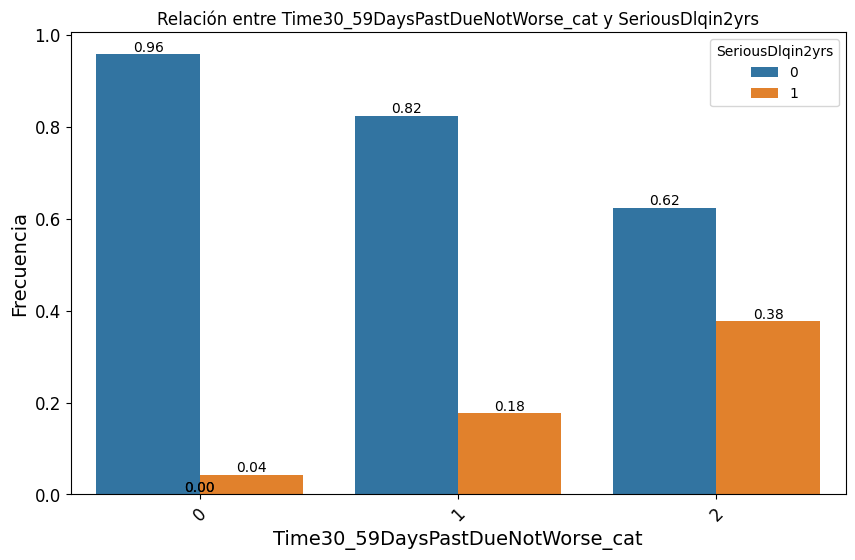

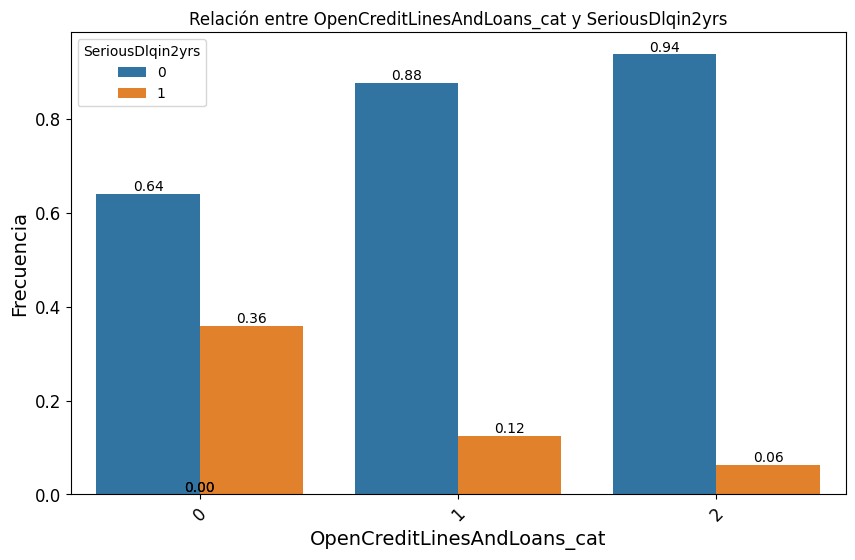

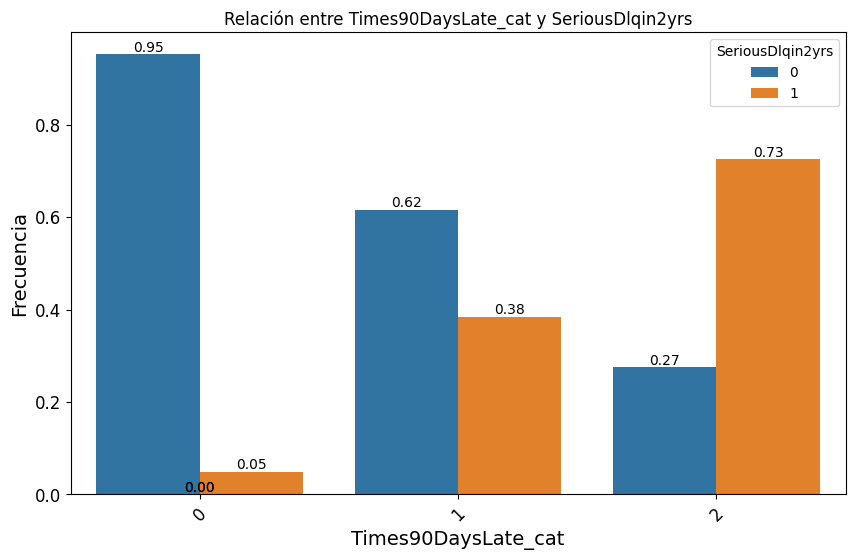

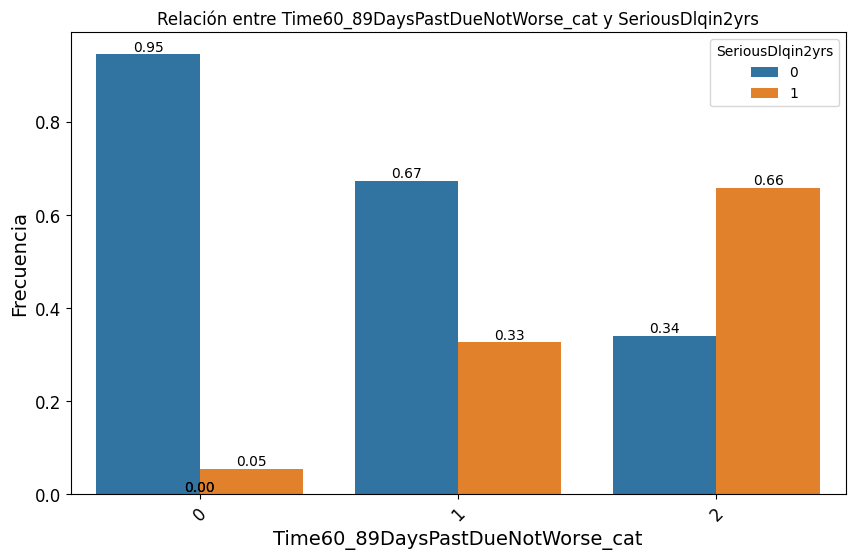

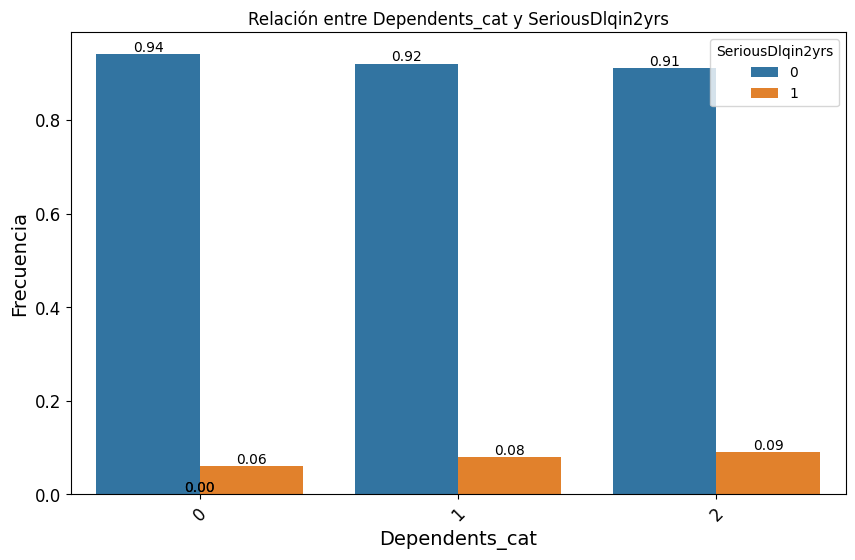

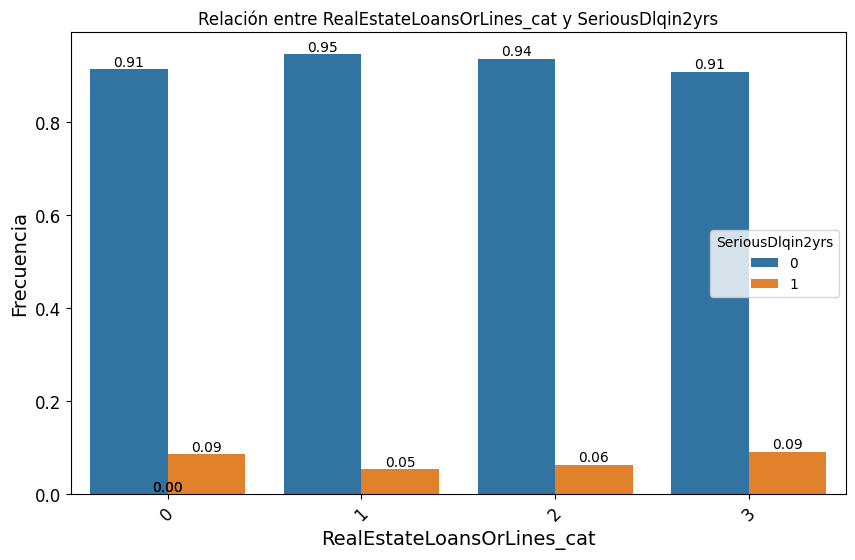

In [177]:
for col in train[cat_cols]:
    viz.plot_categorical_relationship_fin(train, col, target, relative_freq=True, show_values=True)
    

*A excepción de las dos últimas, las demás parecen informativas.*

In [178]:
f_cat_primera = cat_cols[:-2]
f_cat_primera

['Time30_59DaysPastDueNotWorse_cat',
 'OpenCreditLinesAndLoans_cat',
 'Times90DaysLate_cat',
 'Time60_89DaysPastDueNotWorse_cat']

In [179]:
f_visual_primera = f_cat_primera + f_num_primera

#### *ANOVA/SelectKbest y Mutual Information*

*ANOVA/SelectKbest*

In [187]:
selector_anova = SelectKBest(f_classif, k = 3)
selector_anova.fit(train[num_cols], train[target])
f_num_anova_primera = selector_anova.get_feature_names_out().tolist()
f_num_anova_primera

['RevolvingUtilizationOfUnsecuredLines', 'age', 'MonthlyIncome']

In [181]:
pd.DataFrame(dict(features = train[num_cols].columns, score = selector_anova.scores_)).sort_values("score", ascending=False)

,features,score
0,RevolvingUtilizationOfUnsecuredLines,788.269908
1,age,105.857431
3,MonthlyIncome,6.124270
2,DebtRatio,0.000074


In [182]:
dict_mi = {target: []}
for col in cat_cols:
    mi = mutual_info_score(train[target], train[col])
    dict_mi[target].append(mi)
    print(f"Mutual information de {target} y {col}: {mi}")
df_mi = pd.DataFrame(dict_mi, index = cat_cols).sort_values(target, ascending=False)
df_mi

Mutual information de SeriousDlqin2yrs y Time30_59DaysPastDueNotWorse_cat: 0.022835561172795685
Mutual information de SeriousDlqin2yrs y OpenCreditLinesAndLoans_cat: 0.004765953186908832
Mutual information de SeriousDlqin2yrs y Times90DaysLate_cat: 0.035049635400786705
Mutual information de SeriousDlqin2yrs y Time60_89DaysPastDueNotWorse_cat: 0.02012763009492514
Mutual information de SeriousDlqin2yrs y Dependents_cat: 0.0009633014981185739
Mutual information de SeriousDlqin2yrs y RealEstateLoansOrLines_cat: 0.0016891433571061126


,SeriousDlqin2yrs
Times90DaysLate_cat,0.035050
Time30_59DaysPastDueNotWorse_cat,0.022836
Time60_89DaysPastDueNotWorse_cat,0.020128
OpenCreditLinesAndLoans_cat,0.004766
RealEstateLoansOrLines_cat,0.001689
Dependents_cat,0.000963


*Ninguna tiene un nivel muy alto de información mutua, pero está claro que las que más alto lo tienen son las que empiezan por "Time"*

In [183]:
dict_chi = {target: []}
for col in cat_cols:
    tabla_cont = pd.crosstab(train[target], train[col])
    _, p_value, _, _ = chi2_contingency(tabla_cont)
    dict_chi[target].append(p_value)
    print(f"Valor p para el test chi cuadradado de {target} y {col}: {p_value}")
df_chi = pd.DataFrame(dict_chi, index = cat_cols).sort_values(target)
df_chi

Valor p para el test chi cuadradado de SeriousDlqin2yrs y Time30_59DaysPastDueNotWorse_cat: 2.0698757594640955e-135
Valor p para el test chi cuadradado de SeriousDlqin2yrs y OpenCreditLinesAndLoans_cat: 1.4722855149070164e-32
Valor p para el test chi cuadradado de SeriousDlqin2yrs y Times90DaysLate_cat: 1.457133012843841e-285
Valor p para el test chi cuadradado de SeriousDlqin2yrs y Time60_89DaysPastDueNotWorse_cat: 6.092671800741911e-152
Valor p para el test chi cuadradado de SeriousDlqin2yrs y Dependents_cat: 9.734484487773285e-05
Valor p para el test chi cuadradado de SeriousDlqin2yrs y RealEstateLoansOrLines_cat: 5.271184526281863e-07


,SeriousDlqin2yrs
Times90DaysLate_cat,1.457133e-285
Time60_89DaysPastDueNotWorse_cat,6.092672e-152
Time30_59DaysPastDueNotWorse_cat,2.069876e-135
OpenCreditLinesAndLoans_cat,1.472286e-32
RealEstateLoansOrLines_cat,5.271185e-07
Dependents_cat,9.734484e-05


*En todas podemos rechazar la hipótesis nula de que no están relacionadas, sin embargo los valores p son mucho menores para unas que para otras, por lo que me quedo solo con las 3 primeras.*

In [184]:
f_cat_mi_primera = ["Times90DaysLate_cat", "Time60_89DaysPastDueNotWorse_cat", "Time30_59DaysPastDueNotWorse_cat"]

In [188]:
f_anova_mi_primera = f_num_anova_primera + f_cat_mi_primera
f_anova_mi_primera

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'MonthlyIncome',
 'Times90DaysLate_cat',
 'Time60_89DaysPastDueNotWorse_cat',
 'Time30_59DaysPastDueNotWorse_cat']

#### *SelectFromModel*

In [190]:
rfc = RandomForestClassifier(max_depth=5, random_state=42)
selector_model = SelectFromModel(rfc, threshold= "median")
selector_model.fit(train[cat_cols + num_cols], train [target])
f_model = selector_model.get_feature_names_out().tolist()

In [191]:
f_model

['Time30_59DaysPastDueNotWorse_cat',
 'Times90DaysLate_cat',
 'Time60_89DaysPastDueNotWorse_cat',
 'RevolvingUtilizationOfUnsecuredLines',
 'DebtRatio']

#### *RFE*

In [194]:
rfc_1 = RandomForestClassifier(max_depth=5, random_state=42)
rfe = RFE(rfc_1, n_features_to_select= 5, step=1)
rfe.fit(train[cat_cols + num_cols], train [target])
f_rfe = rfe.get_feature_names_out().tolist()
f_rfe

['Time30_59DaysPastDueNotWorse_cat',
 'Times90DaysLate_cat',
 'Time60_89DaysPastDueNotWorse_cat',
 'RevolvingUtilizationOfUnsecuredLines',
 'DebtRatio']

#### *SFS*

In [195]:
rf_sfs = RandomForestClassifier(max_depth=5, random_state=42)

sfs = SequentialFeatureSelector(rf_sfs,
                                n_features_to_select=5,
                                cv=5,
                                scoring= "balanced_accuracy")

sfs.fit(train[cat_cols + num_cols], train [target])

f_sfs = sfs.get_feature_names_out().tolist()
f_sfs

['Time30_59DaysPastDueNotWorse_cat',
 'Times90DaysLate_cat',
 'Time60_89DaysPastDueNotWorse_cat',
 'RevolvingUtilizationOfUnsecuredLines',
 'MonthlyIncome']

#### *Hard-Voting*

In [224]:
metodo_seleccion = ["Visual", "ANOVA/Mutual Information", "Modelo", "RFE", "SFS"]
f_sel = [f_visual_primera, f_anova_mi_primera, f_model, f_rfe, f_sfs]

In [227]:
dict_voting = {col: 0 for col in cat_cols + num_cols}
for col in dict_voting.keys():
    for sel in f_sel:
        if col in sel:
            dict_voting[col] += 1
dict_voting

{'Time30_59DaysPastDueNotWorse_cat': 5,
 'OpenCreditLinesAndLoans_cat': 1,
 'Times90DaysLate_cat': 5,
 'Time60_89DaysPastDueNotWorse_cat': 5,
 'Dependents_cat': 0,
 'RealEstateLoansOrLines_cat': 0,
 'RevolvingUtilizationOfUnsecuredLines': 5,
 'age': 2,
 'DebtRatio': 2,
 'MonthlyIncome': 2}

In [228]:
df_voting = pd.DataFrame(dict_voting, index= ["score"]).T.reset_index().sort_values("score", ascending=False)

In [229]:
df_voting

,index,score
0,Time30_59DaysPastDueNotWorse_cat,5
2,Times90DaysLate_cat,5
6,RevolvingUtilizationOfUnsecuredLines,5
3,Time60_89DaysPastDueNotWorse_cat,5
8,DebtRatio,2
7,age,2
9,MonthlyIncome,2
1,OpenCreditLinesAndLoans_cat,1
5,RealEstateLoansOrLines_cat,0
4,Dependents_cat,0


*Como hay 4 que aparecen en todas y hay un triple empate a 2, me quedo solo con las que aparecen en todas.*

In [230]:
f_hard = df_voting.iloc[0:4, 0].to_list()

#### *Entrenamiento y métricas CV*

*Baseline*

In [235]:
X_train = train[cat_cols + num_cols].copy()
y_train = train[target]

X_test = test[cat_cols + num_cols].copy()
y_test = test[target]

In [242]:
rfc_baseline = RandomForestClassifier(max_depth=5, random_state=42)
cv = cross_val_score(rfc_baseline, X_train, y_train, cv=5, scoring= "balanced_accuracy").mean()
cv

np.float64(0.5500372807842409)

In [232]:
metodo_seleccion = metodo_seleccion + ["Hard_Voting"]
f_sel = f_sel + [f_hard]

In [239]:
len(f_sel)

6

In [240]:
dict_scores = {"n_features": [],
               "cv_decision_tree": [],
               "cv_random_forest": [],
               "cv_lightgbm": []}
for conjunto in f_sel:
    dict_scores["n_features"].append(len(conjunto))
    dtc = DecisionTreeClassifier(max_depth= 5, random_state=42)
    rfc = RandomForestClassifier(max_depth=5, random_state=42)
    lgbmc = LGBMClassifier(max_depth=5, random_state=42, verbose = -1)

    cv_dt = cross_val_score(dtc, X_train[conjunto], y_train, cv = 5, scoring= "balanced_accuracy").mean()
    dict_scores["cv_decision_tree"].append(cv_dt)

    cv_rf = cross_val_score(rfc, X_train[conjunto], y_train, cv = 5, scoring= "balanced_accuracy").mean()
    dict_scores["cv_random_forest"].append(cv_rf)

    cv_lgbm = cross_val_score(lgbmc, X_train[conjunto], y_train, cv = 5, scoring= "balanced_accuracy").mean()
    dict_scores["cv_lightgbm"].append(cv_lgbm)

df_scores = pd.DataFrame(dict_scores, index= metodo_seleccion)

In [241]:
df_scores

,n_features,cv_decision_tree,cv_random_forest,cv_lightgbm
Visual,6,0.575477,0.563224,0.591462
ANOVA/Mutual Information,6,0.584331,0.565673,0.595564
Modelo,5,0.569696,0.570720,0.596852
RFE,5,0.569696,0.570720,0.596852
SFS,5,0.577986,0.573803,0.591372
Hard_Voting,4,0.558206,0.577020,0.583892


*Por lo general han obtenido una métrica mejor que la de nuestro baseline, que era un random forest y obtuvo un 55% de recall medio, voy a optimizar el lightgbm con las features obtenidas mediante RFE, por ser el que mejor métrica tiene, aunque no por mucho.*

In [245]:
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 6, 12],
    "num_leaves": [15, 31, 60, 120],
    "learning_rate": [0.1, 0.5, 1],
    "class_weight": ["balanced", None],
    "min_child_samples": [1, 10, 20, 50],
    "colsample_bytree": [0.5, 1],
}

clf = LGBMClassifier()

lgbmc_rs = RandomizedSearchCV(
    clf,
    param_distributions= param_grid,
    scoring = "balanced_accuracy",
    n_iter = 70,
    cv=5,
    random_state=42,
    n_jobs = -1,
    verbose= 0
)
lgbmc_rs.fit(X_train[f_rfe], y_train)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=70, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'colsample_bytree': [0.5, 1],
                                        'learning_rate': [0.1, 0.5, 1],
                                        'max_depth': [3, 6, 12],
                                        'min_child_samples': [1, 10, 20, 50],
                                        'n_estimators': [100, 200, 400],
                                        'num_leaves': [15, 31, 60, 120]},
                   random_state=42, scoring='balanced_accuracy')

In [247]:
lgbmc_rs.best_score_

np.float64(0.7451509603312845)

In [248]:
lgbmc_rs.best_params_

{'num_leaves': 60,
 'n_estimators': 200,
 'min_child_samples': 20,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 1,
 'class_weight': 'balanced'}

In [249]:
lgbmc_opt = lgbmc_rs.best_estimator_
pred_test = lgbmc_opt.predict(X_test[f_rfe])
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2198
           1       0.20      0.68      0.31       166

    accuracy                           0.78      2364
   macro avg       0.58      0.74      0.59      2364
weighted avg       0.92      0.78      0.83      2364



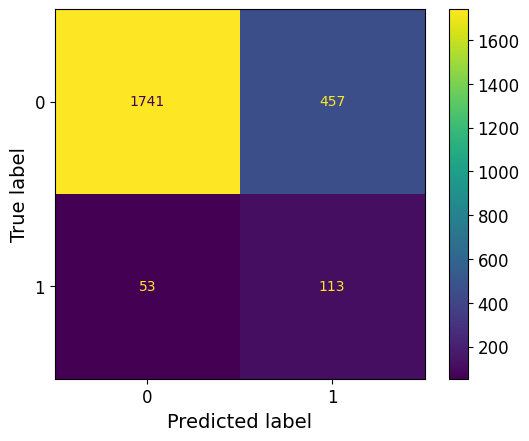

In [250]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, pred_test)

*Al optimizarlo hemos aumentado el recall, pero a cambio de una precisión muy baja, detectaremos al 74% de las personas que van a incurrir en impago, pero a cambio de predecir que muchas personas que no incurrirán en impago sí que lo harán, este no es un gran modelo, tendríamos que preguntar a negocio cuál es la mayor prioridad y si este modelo le vale o aceptaría reducir un poco el recall a cambio de aumentar un poco la precisión y hasta qué punto.*

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.